## Job-Shop Scheduling Problem

This notebook demonstrates how to model and solve the classical Job-Shop Scheduling Problem using Constraint Programming with IBM’s CP Optimizer via the [docplex.cp](https://ibmdecisionoptimization.github.io/docplex-doc/cp/refman.html) Python API, and subsequently solving the problem in OptalCP via the OptalCP [Python API](https://github.com/ScheduleOpt/optalcp-py).

### Problem Definition

In the Job-Shop Scheduling Problem, we have a finite set of jobs $i \in \{1,\dots,N\}$ to be scheduled on a finite set of machines $k \in \{1,\dots,M\}$, with the objective of minimizing the makespan $C_{\max}$—the total length of the schedule. Each job $i$ consists of a predefined sequence of operations $x_{i1}, x_{i2}, \dots, x_{iM}$ that must be processed in a fixed order (precedence constraints): operation $x_{ij}$ may start only after $x_{i,j-1}$ has completed. Each operation $x_{ij}$ of a job $i$ is assigned to a specific machine $MC_{ij} \in \{1,\dots,M\}$ and has a known processing time $PT_{ij} > 0$. At any time, each machine $k \in \{1,\dots,M\}$ can process at most one operation.


### CP Formulation

$$
\begin{aligned}
\min \quad & \max_{i \in [1..N]} \text{endOf}(x_{iM}) \quad & \quad & \text{(1)} \\
\text{s.t.} \quad
& \text{noOverlap}([x_{ij}]_{i,j \in [1..N]\times[1..M]: MC_{ij}=k}), \quad & \forall k \in [1..M] \quad & \text{(2)} \\
& \text{endBeforeStart}(x_{i,j-1}, x_{ij}), \quad & \forall i \in [1..N],\ j \in [2..M] \quad & \text{(3)} \\
& \text{interval } x_{ij},\ \text{size} = PT_{ij}, \quad & \forall i \in [1..N],\ j \in [1..M] \quad & \text{(4)}
\end{aligned}
$$

Objective:
- **(1)** The makespan $C_{\max}$ — the completion time of the last finishing job — is **minimized**.

Modeling contraints:
- **(2)** No two operations processed on the same machine overlap in time.
- **(3)** The order of operations within each job is respected.

Variables:
- **(4)** $x_{ij}$: interval variable representing operation $(i,j)$ with fixed duration $PT_{ij}$ on machine $MC_{ij}$.

#### Symbols and Notation

| Symbol / Function | Meaning | DOcplex reference | OptalCP reference |
|---|---|---|---|
| $N$ | Number of jobs | — | — |
| $M$ | Number of machines | — | — |
| $i$ | Job index ($i \in [1..N]$) | — | — |
| $j$ | Operation index within a job ($j \in [1..M]$) | — | — |
| $k$ | Machine index ($k \in [1..M]$) | — | — |
| $x_{ij}$ | Interval variable representing operation $j$ of job $i$ | — | — |
| $\text{endOf}(x_{ij})$ | End time of operation $x_{ij}$ | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) | [interval_var.end](https://optalcp.com/docs/api/classes/IntervalVar#end) |
| $MC_{ij}$ | Machine assigned to operation $x_{ij}$ | — | — |
| $PT_{ij}$ | Processing time (duration) of operation $x_{ij}$ | — | — |
| $\text{noOverlap}(\cdot)$ | Ensures that operations using the same machine do not overlap in time | [docplex.cp.modeler.no_overlap](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.no_overlap) | [model.no_overlap](https://optalcp.com/docs/api/classes/Model#nooverlap) |
| $\text{endBeforeStart}(x_{i,j-1}, x_{ij})$ | Enforces operation $j$ starts after operation $j-1$ of the same job finishes | [docplex.cp.modeler.end_before_start](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) | [interval_var.end_before_start](https://optalcp.com/docs/api/classes/IntervalVar#endbeforestart) |
| $\text{interval } x_{ij}, \text{ size}=PT_{ij}$ | Declares $x_{ij}$ as an interval variable with duration $PT_{ij}$ | [docplex.cp.expression.interval_var](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html#docplex.cp.expression.interval_var) | [interval_var](https://optalcp.com/docs/api/classes/IntervalVar) |
| $\max_{i \in [1..N]} \text{endOf}(x_{iM})$ | Represents the makespan (the time when the last job finishes) | [docplex.cp.modeler.end_of](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_of) | [interval_var.end](https://optalcp.com/docs/api/classes/IntervalVar#end) |
| $C_{\max}$ | Overall completion time (makespan) of the schedule | — | — |

### Data Import & Parsing

In [1]:
import json
from pathlib import Path

In [2]:
def load_jobshop(instance_name, json_path):
    """Load jobshop instance by name."""
    json_file = Path(json_path)
    with open(json_file) as f:
        meta = next(m for m in json.load(f) if m["name"] == instance_name)
    
    with open(json_file.parent / meta["path"]) as f:
        N, M = map(int, next(l for l in f if not l.startswith('#')).split())
        MC, PT = [], []
        for _ in range(N):
            v = list(map(int, f.readline().split()))
            MC.append([v[2*j] for j in range(M)])
            PT.append([v[2*j+1] for j in range(M)])
    
    return N, M, MC, PT, meta.get("optimum")

In [3]:
N, M, MC, PT, opt = load_jobshop(instance_name="abz5", json_path="../data/jobshop/JSPLIB/instances.json")

In [4]:
print(f"--- Instance Summary ---\nDimensions : {N} Jobs x {M} Machines\nOptimum: {opt}\
      \n{'-'*50}\n{'Job':<4} | {'Sequence (Machine, Time)':<10}\n{'-'*50}")
for i in range(N): print(f"{i:<4} | " + " ".join(f"({m},{t})" for m, t in zip(MC[i], PT[i])))

--- Instance Summary ---
Dimensions : 10 Jobs x 10 Machines
Optimum: 1234      
--------------------------------------------------
Job  | Sequence (Machine, Time)
--------------------------------------------------
0    | (4,88) (8,68) (6,94) (5,99) (1,67) (2,89) (9,77) (7,99) (0,86) (3,92)
1    | (5,72) (3,50) (6,69) (4,75) (2,94) (8,66) (0,92) (1,82) (7,94) (9,63)
2    | (9,83) (8,61) (0,83) (1,65) (6,64) (5,85) (7,78) (4,85) (2,55) (3,77)
3    | (7,94) (2,68) (1,61) (4,99) (3,54) (6,75) (5,66) (0,76) (9,63) (8,67)
4    | (3,69) (4,88) (9,82) (8,95) (0,99) (2,67) (6,95) (5,68) (7,67) (1,86)
5    | (1,99) (4,81) (5,64) (6,66) (8,80) (2,80) (7,69) (9,62) (3,79) (0,88)
6    | (7,50) (1,86) (4,97) (3,96) (0,95) (8,97) (2,66) (5,99) (6,52) (9,71)
7    | (4,98) (6,73) (3,82) (2,51) (1,71) (5,94) (7,85) (0,62) (8,95) (9,79)
8    | (0,94) (6,71) (3,81) (7,85) (1,66) (2,90) (4,76) (5,58) (8,93) (9,97)
9    | (3,50) (0,59) (1,82) (8,67) (7,56) (9,96) (6,58) (4,81) (5,59) (2,96)


### IBM CPO Docplex Implementation

> This notebook is an adaptation of the *Jobshop-basic* example from the [IBM Decision Optimization CPLEX Modeling for Python (DOcplex) Examples Repository](https://github.com/IBMDecisionOptimization/docplex-examples/tree/master).  

#### Imports

In [5]:
from docplex.cp.model import CpoModel, interval_var, no_overlap, end_before_start, end_of, minimize
import docplex.cp.utils_visu as visu
import matplotlib.pyplot as plt

#### Create model and variables

In [6]:
# Create a CP Optimizer model
mdl = CpoModel(name="JobShopCPOptimizer")

# (4) Define interval variables for each operation x_ij with duration PT_ij
x = [
    [interval_var(size=PT[i][j], name=f"x_{i}_{j}") for j in range(M)]
    for i in range(N)
]

#### Add constraints and define objective

In [7]:
# (1) Objective: minimize makespan = max_i endOf(last op of job i)
mdl.add(minimize(mdl.max(end_of(x[i][M-1]) for i in range(N))))

# (2) Machine capacity: each machine can process only one operation at a time
mdl.add([no_overlap([x[i][j] for i in range(N) for j in range(M) if MC[i][j] == k])
         for k in range(M)])

# (3) Technological order: each operation j of job i starts after operation j-1 ends
mdl.add([end_before_start(x[i][j-1], x[i][j])
        for i in range(N) for j in range(1, M)])

#### Solve the model

In [8]:
print('Solving model...')
res = mdl.solve(TimeLimit=10, LogVerbosity='Quiet')
print('Solution:')
res.print_solution()

Solving model...
Solution:
-------------------------------------------------------------------------------
Model constraints: 100, variables: integer: 0, interval: 100, sequence: 10
Solve status: Optimal
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 2.45 sec
-------------------------------------------------------------------------------
Objective values: (1234,), bounds: (1234,), gaps: (0,)
Variables:
   x_0_0 = IntervalVarValue(start=267, end=355, size=88)
   x_0_1 = IntervalVarValue(start=379, end=447, size=68)
   x_0_2 = IntervalVarValue(start=497, end=591, size=94)
   x_0_3 = IntervalVarValue(start=591, end=690, size=99)
   x_0_4 = IntervalVarValue(start=690, end=757, size=67)
   x_0_5 = IntervalVarValue(start=774, end=863, size=89)
   x_0_6 = IntervalVarValue(start=863, end=940, size=77)
   x_0_7 = IntervalVarValue(start=954, end=1053, size=99)
   x_0_8 = IntervalVarValue(start=1053, end=1139, size=86)
   x_0_9 = IntervalVarValue(start=1141, end=1

#### Visualisation

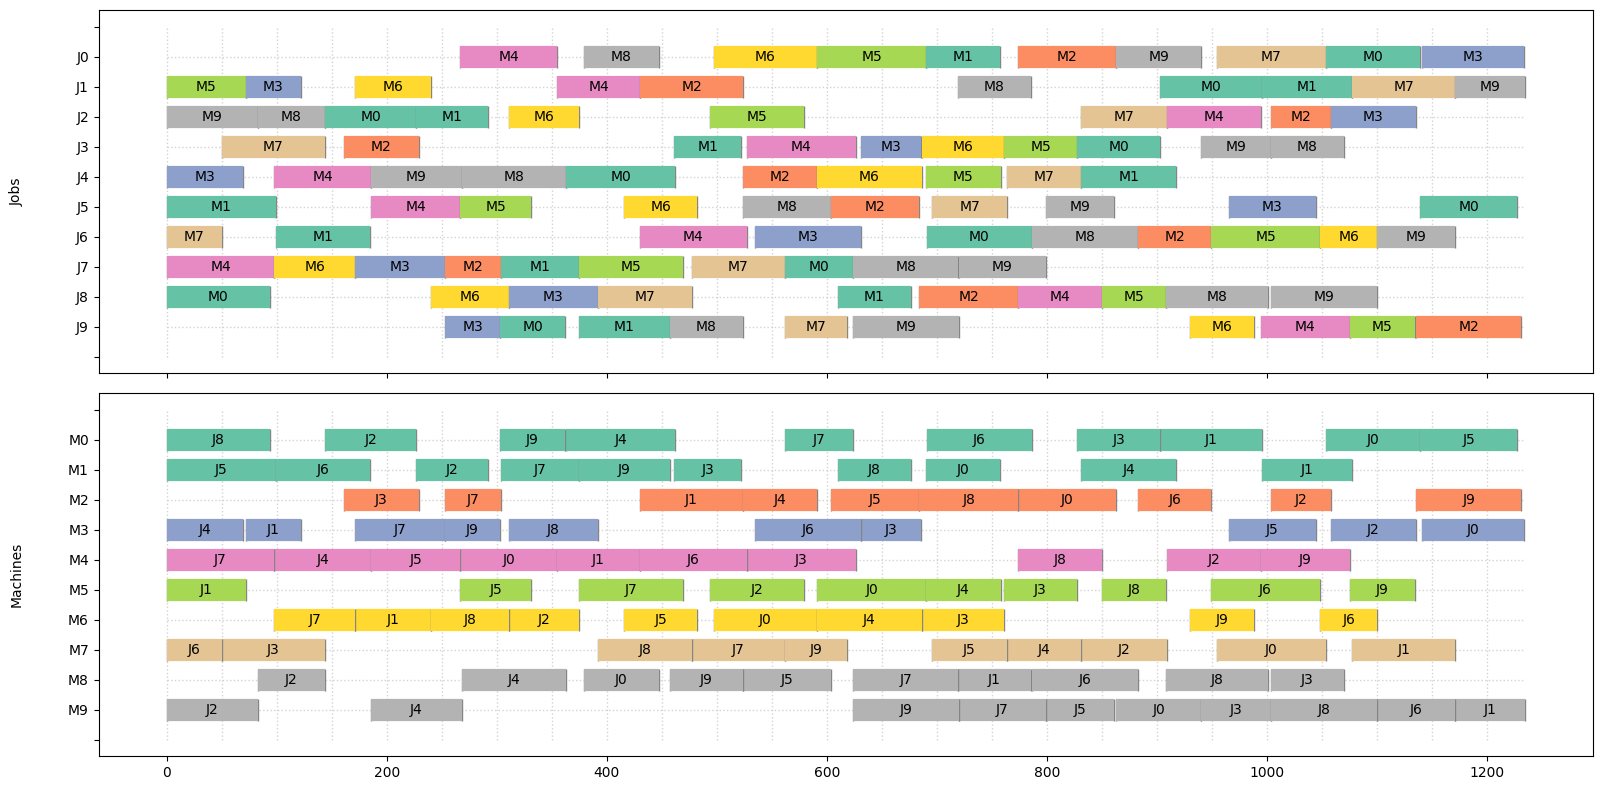

In [9]:
if res and res.is_solution() and visu.is_visu_enabled():
    plt.rcParams["figure.figsize"] = (16, 8)
    visu.panel('Jobs')
    for i in range(N):
        visu.sequence(
            name=f'J{i}',
            intervals=[(res.get_var_solution(x[i][j]), MC[i]
                        [j], f'M{MC[i][j]}') for j in range(M)]
        )
    visu.panel('Machines')
    for k in range(M):
        intervals = []
        for i in range(N):
            for j in range(M):
                if MC[i][j] == k:
                    intervals.append(
                        (res.get_var_solution(x[i][j]), k, f'J{i}'))
        visu.sequence(name=f'M{k}', intervals=intervals)

    visu.show()

### OptalCP Implementation

In [10]:
import optalcp as cp

In [11]:
# Create OptalCP model
mdl = cp.Model(name="JobShopOptal")

# (4) Define interval variables for each operation x_ij with duration PT_ij
x = [
    [mdl.interval_var(length=PT[i][j], name=f"x_{i}_{j}") for j in range(M)]
    for i in range(N)
]

In [12]:
# (1) Objective: minimize makespan = max_i endOf(last op of job i)
mdl.minimize(mdl.max([x[i][M-1].end() for i in range(N)]))

# (2) Machine capacity: each machine can process only one operation at a time
for k in range(M):
    mdl.no_overlap([x[i][j] for i in range(N) for j in range(M) if MC[i][j] == k])

# (3) Technological order: each operation j of job i starts after operation j-1 ends
for i in range(N):
    for j in range(1, M):
        x[i][j-1].end_before_start(x[i][j])

In [13]:
print('Solving model...')
params = cp.Parameters()
params.timeLimit = 10
result = cp.solve(mdl, params)

Solving model...
--------------------------------------------------------------------------------
                         ScheduleOpt OptalCP [Academic]
                           Version 2025.11.1 (Linux)
                CPU: AMD Ryzen 5 5500U with (12 physical cores)
--------------------------------------------------------------------------------
Input parse time: 00:00
Parameters:
   TimeLimit = 10 seconds
Input: JobShopOptal
   0 integer variables, 100 interval variables, 100 constraints, 36.9kB
   00:00 Presolving..
Presolved:
   0 integer variables, 100 interval variables, 100 constraints, 33.1kB
   00:00 Starting the search using 12 workers (physical cores count).
--------------------------------------------------------------------------------
   00:00 Lower bound 859 Worker 0
   00:00 Lower bound 860 Worker 0
   00:00 Lower bound 862 Worker 0
   00:00 Lower bound 865 Worker 0
   00:00 Lower bound 870 Worker 0
   00:00 Lower bound 879 Worker 0
   00:00 Lower bound 896 Worker 0


In [14]:
result

<SolveResult: 14 solution(s), objective=1234.0, duration=10.01s>

### Additional Resources

- **IBM DOcplex CP – Job Shop Basic**
  - https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/visu/job_shop_basic.py

- **IBM DOcplex CP – Flexible Job Shop**
  - https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/visu/job_shop_flexible.py
  - Flexible JSSP where operations can choose among alternative machines (routing decisions).

- **IBM DOcplex CP – Stochastic Job Shop**
  - https://github.com/IBMDecisionOptimization/docplex-examples/blob/master/examples/cp/visu/job_shop_stochastic.py
  - Models uncertainty (e.g., durations) with scenario-based or stochastic constructs.
  
- **JSPLIB** – Benchmark instances for the job-shop scheduling problem (minimizing makespan).
  - https://github.com/tamy0612/JSPLIB